In [1]:
"""
This code belongs to the paper:
-- Y.C. Mathpati, K.S. More, T. Tripura, R. Nayek, S. Chakraborty (2023)
   MAntRA: A framework for model agnostic reliability analysis
   
-- This code is for 5-DOF linear structural system with tuned mass damper.
"""

'\nThis code belongs to the paper:\n-- Y.C. Mathpati, K.S. More, T. Tripura, R. Nayek, S. Chakraborty (2023)\n   MAntRA: A framework for model agnostic reliability analysis\n   \n-- This code is for 5-DOF linear structural system with tuned mass damper.\n'

In [1]:
import numpy as np
from numpy import linalg as LA
from numpy.random import gamma as IG
from numpy.random import beta
from numpy.random import binomial as bern
from numpy.random import multivariate_normal as mvrv
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as LA
from sklearn.metrics import mean_squared_error as MSE

"""
The Dictionary creation part:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""
def library(xt, polyn, harmonic):
    if polyn == 0:
        polyn = 1
    
    # The polynomial is (x1 + x2)^p, with p is the order
    # poly order 0
    ind = 0
    n = len(xt[0])
    D = np.ones([n,1])
    
    if polyn >= 1:
        # poly order 1
        for i in range(len(xt)):
            ind = ind+1
            new = np.vstack(xt[i,:])
            D = np.append(D, new, axis=1)
     
    if polyn >= 2: 
        # ploy order 2
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                ind = ind+1
                new = np.multiply(xt[i,:], xt[j,:])
                new = np.vstack(new)
                D = np.append(D, new, axis=1) 
    
    if polyn >= 3:    
        # ploy order 3
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    ind = ind+1
                    new = np.multiply(np.multiply(xt[i,:], xt[j,:]), xt[k,:])
                    new = np.vstack(new)
                    D = np.append(D, new, axis=1) 
    
    if polyn >= 4:
        # ploy order 4
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    for l in range(k,len(xt)):
                        ind = ind+1
                        new = np.multiply(np.multiply(xt[i,:], xt[j,:]), xt[k,:])
                        new = np.multiply(new, xt[l,:])
                        new = np.vstack(new)
                        D = np.append(D, new, axis=1) 
    
    if polyn >= 5:
        # ploy order 5
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    for l in  range(k,len(xt)):
                        for m in  range(l,len(xt)):
                            ind = ind+1
                            new = np.multiply(xt[i,:], xt[j,:])
                            new = np.multiply(new, xt[k,:])
                            new = np.multiply(new, xt[l,:])
                            new = np.multiply(new, xt[m,:])
                            new = np.vstack(new)
                            D = np.append(D, new, axis=1) 
    
    if polyn >= 6:
        # ploy order 6
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    for l in  range(k,len(xt)):
                        for m in  range(l,len(xt)):
                            for n in  range(m,len(xt)):
                                ind = ind+1
                                new = np.multiply(xt[i,:], xt[j,:])
                                new = np.multiply(new, xt[k,:])
                                new = np.multiply(new, xt[l,:])
                                new = np.multiply(new, xt[m,:])
                                new = np.multiply(new, xt[n,:])
                                new = np.vstack(new)
                                D = np.append(D, new, axis=1) 
    
    
    # for the modulus operator
    for i in range(len(xt)):
        ind = ind+1
        new = np.vstack(abs(xt[i,:]))
        D = np.append(D, new, axis=1)
      
    # for the tensor operator
    for i in range(len(xt)):
        for j in  range(len(xt)):
            ind = ind+1
            new = np.multiply(xt[i,:],abs(xt[j,:]))
            new = np.vstack(new)
            D = np.append(D, new, axis=1)
            
    if harmonic == 1:
        # for sin(x)
        for i in range(len(xt)):
            ind = ind+1
            new = np.vstack(np.sin(xt[i,:]))
            D = np.append(D, new, axis=1)
            #  or,
            # ind = ind+1
            # new = np.sin(xt[i,:])
            # D = np.insert(D, ind, new, axis=1)
            
        # for cos(x)
        for i in range(len(xt)):
            ind = ind+1
            new = np.vstack(np.cos(xt[i,:]))
            D = np.append(D, new, axis=1)
    
 
    ind = len(D[0])
    
    return D, ind

"""
A Duffing Van der pol system excited by random noise
----------------------------------------------------------------------
"""
def duffing(x1, x2, T):

    # parameters of Duffing oscillator in Equation
    m = 1
    c = 2
    k = 1000
    k3 = 100000
    sigma = 10
    
    # solution by Taylor 1.5 strong scheme Run with dt=0.01
    # -------------------------------------------------------
    # T = 1
    dt = 0.001
    t = np.arange(0, T+dt, dt)
    Nsamp = 200 # no. of samples in the run
    delmat = np.row_stack(([np.sqrt(dt), 0],[(dt**1.5)/2, (dt**1.5)/(2*np.sqrt(3))]))
    
    y1 = []
    y2 = []
    xz = []
    xzs = []
    # Simulation Starts Here ::
    # -------------------------------------------------------
    for ensemble in range(Nsamp):
        x0 = np.array([x1, x2])
        x = np.vstack(x0)  # Zero initial condition.
        for n in range(len(t)-1):

            delgen = np.dot(delmat, np.random.normal(0,1,2))
            dW = delgen[0]
            dZ = delgen[1]
            a1 = x0[1]
            a2 = -(c/m)*x0[1]-(k/m)*x0[0]-(k3/m)*(x0[0]**3)
            b2 = (sigma/m) * x0[0]

            sol1 = x0[0] + a1*dt 
            sol2 = x0[1] + a2*dt + b2*dW 
            x0 = np.array([sol1, sol2])
            x = np.column_stack((x, x0))
        y1.append(x[0,:])
        y2.append(x[1,:])
        
        zint = x[1,0:-1]
        xfinal = x[1,1:] 
        xmz = (xfinal - zint) # 'x(t)-z' vector
        xmz2 = np.multiply(xmz, xmz)
        xz.append(xmz)
        xzs.append(xmz2)
        
    xz = pow(dt,-1)*np.mean(np.array(xz), axis = 0)
    xzs = pow(dt,-1)*np.mean(np.array(xzs), axis = 0)
    
    y1 = np.array(y1)
    y2 = np.array(y2)
    time = t[0:-1]
    
    return xz, xzs, y1, y2, time

1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
71
72
73
74
75
76
77
78
79
81
82
83
84
85
86
87
88
89
91
92
93
94
95
96
97
98
99
Iteration = 0  log(Likelihood) = 3937.2357779388108
Iteration = 1  log(Likelihood) = 5304.571146965922
Iteration = 2  log(Likelihood) = 5457.868329688951
Iteration = 3  log(Likelihood) = 5458.643681327865
Iteration = 4  log(Likelihood) = 5458.644102945878
Iteration = 5  log(Likelihood) = 5458.644103125316
{'zmean': array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), 'wmean': array([1.03286603e-17, 0.00000000e+00, 0.00000000e+00, 6.89656895e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.0000

C:\Users\USER\AppData\Local\Temp/ipykernel_11272/559932011.py:314: RuntimeWarning: overflow encountered in exp
  expitC = 1./(1 + np.exp(-C))
C:\Users\USER\AppData\Local\Temp/ipykernel_11272/559932011.py:286: RuntimeWarning: divide by zero encountered in log
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
C:\Users\USER\AppData\Local\Temp/ipykernel_11272/559932011.py:286: RuntimeWarning: invalid value encountered in multiply
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
C:\Users\USER\AppData\Local\Temp/ipykernel_11272/559932011.py:287: RuntimeWarning: divide by zero encountered in log
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))
C:\Users\USER\AppData\Local\Temp/ipykernel_11272/559932011.py:287: RuntimeWarning: invalid value encountered in multiply
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))


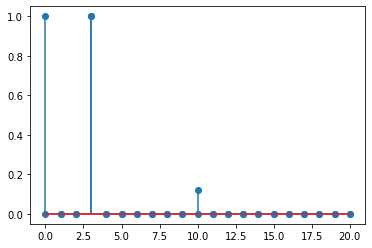

In [21]:
import numpy as np
from numpy import linalg as LA
from numpy.random import gamma as IG
from numpy.random import beta
from numpy.random import binomial as bern
import fun_library0
import fun_gibbs
import fun_resp_stochastic
from numpy.random import multivariate_normal as mvrv
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

T = 1
np.random.seed(4)
# Response generation:
x1, x2 = 0.005, 0 # initial displacement condition
gg, xbt, y1, y2, t_eval = duffing(x1, x2, T)

# Dictionary Creation:
libr = []
for j in range(len(y1)):
    data = np.row_stack((y1[j,0:-1], y2[j,0:-1]))
    Dtemp, nl = library(data, 4, 0)
    libr.append(Dtemp)
libr = np.array(libr)
D = np.mean(libr, axis = 0)
# Bayesian Interference:
# D, xdts, muD, sdvD = fun_library0.BayInt(D, xbt)
xdts = xbt

# Adding 5% of the std. of acceleration as noise:
# xdts = xdts + np.random.normal(0, 0.1*np.std(xdts), len(xdts))

# Residual variance:
err_var = fun_library0.res_var(D, xdts)

"""
# Gibbs sampling:
"""
# Hyper-parameters
ap, bp = 0.1, 1 # for beta prior for p0
av, bv = 0.5, 0.5 # inverge gamma for vs
asig, bsig = 1e-4, 1e-4 # invese gamma for sig^2

# Parameter Initialisation:
MCMC = 100  # No. of samples in Markov Chain,
p0 = np.zeros(MCMC)
vs = np.zeros(MCMC)
sig = np.zeros(MCMC)
p0[0] = 0.1
vs[0] = 10
sig[0] = err_var

N = len(xdts)

# Initial latent vector
zval = np.zeros(nl)
zint  = fun_library0.latent(nl, D, xdts)
zstore = np.transpose(np.vstack([zint]))
zval = zint

zval0 = zval
vs0 = vs[0]
mu, BSIG, Aor, index = fun_gibbs.sigmu(zval0, D, vs0, xdts)
Sz = sum(zval)

# Sample theta from Normal distribution
thetar = mvrv(mu, np.dot(sig[0], BSIG))
thetat = np.zeros(nl)
thetat[index] = thetar
theta = np.vstack(thetat)

for i in range(1, MCMC):
    if i%10:
        print(i)
    
    # sample z from the Bernoulli distribution:
    zr = np.zeros(nl) # instantaneous latent vector (z_i):
    zr = zval
    for j in range(nl):
        ztemp0 = zr
        ztemp0[j] = 0
        if np.mean(ztemp0) == 0:
            PZ0 = fun_gibbs.pyzv0(xdts, N, asig, bsig)
        else:
            vst0 = vs[i-1]
            PZ0 = fun_gibbs.pyzv(D, ztemp0, vst0, N, xdts, asig, bsig)
        
        ztemp1 = zr
        ztemp1[j] = 1      
        vst1 = vs[i-1]
        PZ1 = fun_gibbs.pyzv(D, ztemp1, vst1, N, xdts, asig, bsig)
        
        zeta = PZ0 - PZ1  
        zeta = p0[i-1]/( p0[i-1] + np.exp(zeta)*(1-p0[i-1]))
        zr[j] = bern(1, p = zeta, size = None)
    
    zval = zr
    zstore = np.append(zstore, np.vstack(zval), axis = 1)
    
    # sample sig^2 from inverse Gamma:
    asiggamma = asig+0.5*N
    temp = np.matmul(np.matmul(mu.T, LA.inv(BSIG)), mu)
    bsiggamma = bsig+0.5*(np.dot(xdts.T, xdts) - temp)
    sig[i] = 1/IG(asiggamma, 1/bsiggamma) # inverse gamma RVs
    
    # sample vs from inverse Gamma:
    avvs = av+0.5*Sz
    bvvs = bv+(np.matmul(np.matmul(thetar.T, LA.inv(Aor)), thetar))/(2*sig[i])
    vs[i] = 1/IG(avvs, 1/bvvs) # inverse gamma RVs
    
    # sample p0 from Beta distribution:
    app0 = ap+Sz
    bpp0 = bp+nl-Sz # Here, P=nl (no. of functions in library)
    p0[i] = beta(app0, bpp0)
    # or, np.random.beta()
    
    # Sample theta from Normal distribution:
    vstheta = vs[i]
    mu, BSIG, Aor, index = fun_gibbs.sigmu(zval, D, vstheta, xdts)
    Sz = sum(zval)
    thetar = mvrv(mu, np.dot(sig[i], BSIG))
    thetat = np.zeros(nl)
    thetat[index] = thetar
    theta = np.append(theta, np.vstack(thetat), axis = 1)

zstorediff = zstore[:, 51:]    
Zmeandiff = np.mean(zstorediff, axis=1)

thetadiff = theta[:,51:]
mutdiff = np.mean(thetadiff, axis=1)
sigtdiff = np.cov(thetadiff, bias = False)

# Post processing:
mutind = np.where(mutdiff<(np.max(np.abs(mutdiff))*0.02))
Zmeandiff[mutind] = Zmeandiff[mutind]*1e-3
# thetanor = thetadiff[3,:] - np.abs(thetadrift[1,:])
# munormal = np.mean(thetanor)

plt.stem(Zmeandiff)

import warnings
import math
import numpy as np
import scipy as sp
import sympy as smp
from scipy import stats
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy.random import gamma
from scipy.special import loggamma

def Variational_Bayes_Code(X, y, initz0, tol, verbosity):

    if (len(X) == 0 or len(y) == 0):
        raise Exception('X and or y is missing')
        
    if (len(X) != len(y)):
        raise Exception('Number of observations do not match')
        
    X = stats.zscore(X, ddof = 1)         
    X = np.c_[np.ones(len(X)),X]          
    y = y - np.mean(y)
    N = len(X)
    # Prior parameters of noise variance (Inverse Gamma dist)
    A = 1e-4
    B = 1e-4
    vs = 10
    tau0 = 1000
    
    if (len(initz0) == 0):
        raise Exception('No initial value of z found')
    else:
        p0 = expit(-0.5*(np.sqrt(N)))       
        
        # Adding the intercept indicator variable (slightly less than 1 to prevent log(0) values) 
        initz = np.hstack((1,initz0))   

        DS,LLcvg  = run_VB2(X, y, vs, A, B, tau0, p0, initz, tol, verbosity)    
        # This is function which will come first
        
    out_vb   = DS
    a = DS['zmean'] > 0.5
    count = 0
    modelIdx = []
    for i in a:
        if i == True:
            modelIdx.append(count)
        count += 1
            
    modelIdx = np.setdiff1d(modelIdx,0)
    out_vb['modelIdx'] = modelIdx-1
    out_vb['Zmed'] = DS['zmean'][modelIdx]
    out_vb['Wsel'] = DS['wmean'][modelIdx]
    out_vb['Wcov'] = DS['wCOV'][modelIdx, modelIdx]
    out_vb['sig2'] = DS['sig2']
    
    return out_vb

DS = {}
def run_VB2(Xc, yc, vs, A, B, tau0, p0, initz, tol, verbosity):
    """This function is the implementation of VB from John T. Ormerod paper (2014)
       This implementation uses slab scaling by noise variance
       vs    : treated as a constant
       A,B   : constants of the IG prior over noise variance
       tau0  : Expected value of (sigma^{-2})
       p0    : inclusion probablility
       initz : Initial value of z
       Xc    : Centered and standardized dictionary except the first column
       yc    : Centered observations """
    
    Lambda    = logit(p0)
    iter_     = 0
    max_iter  = 100
    LL        = np.zeros(max_iter)        
    zm        = np.reshape(initz,(-1))            
    taum      = tau0                      
    invVs     = 1/vs
    
    X = Xc
    y = yc
    XtX = (X.T) @ X
    XtX = 0.5*(XtX + (XtX).T)
    Xty = (X.T) @ y                 
    yty = (y.T) @ y

    eyep = np.eye(len(XtX))
    [N,p] = X.shape
    allidx = np.arange(p)
    zm[0] = 1                                                                   # Always include the intercept 
    Abar    = (A + 0.5*N + 0.5*p)
    converged = 0
    
    while (converged==0):
        if (iter_==100):
            break
        
        Zm       = np.diag(zm)
        Omg      = (np.reshape(zm,(-1,1)) @ np.reshape(zm,(1,-1))) + (Zm @ (eyep-Zm))
        # Update the mean and covariance of the coefficients given mean of z
        term1    = XtX * Omg                                                       # elementwisw multiplication
        invSigma = taum * (term1 + invVs * eyep)
        invSigma = 0.5*(invSigma + invSigma.T)                                     # symmetric
        Sigma    = la.inv(invSigma) @ eyep
        mu       = taum * (Sigma @ Zm @ Xty)                                       # @ ---> matrix multiplication
        
        # Update tau related to sigma
        term2    = 2 * Xty @ Zm @ mu
        term3    =  np.reshape(mu,(len(initz0)+1,1)) @ np.reshape(mu,(1,len(initz0)+1))+ Sigma
        term4    = yty - term2 + np.trace((term1 + invVs * eyep) @ term3)    
        s        = B + 0.5*term4
        
        if s<0:
            warnings.warn('s turned out be less than 0. Taking absolute value')
            s = B + 0.5*abs(term4)
        
        taum     = Abar / s
        zstr   = zm

        order   = np.setdiff1d(np.random.permutation(p), 0, assume_unique=True)
        for j in order: 
            muj     = mu[j]                            
            sigmaj  = Sigma[j,j]
            
            remidx  = np.setdiff1d(allidx,j)
            mu_j    = mu[remidx]
            Sigma_jj= Sigma[remidx,j]
            etaj    = (Lambda - 0.5 * taum * ((muj**2 + sigmaj) * XtX[j,j]) 
                       + taum * np.reshape(X[:,j],(1,-1)) @ (np.reshape(y,(-1,1))*muj 
                        -X[:,remidx] @ np.diag(zstr[remidx]) @ ((mu_j * muj + Sigma_jj).reshape(-1,1))))
            zstr[j] = expit(etaj)
            
        zm = zstr
        
        # Calculate marginal log-likelihood
        
        LL[iter_] = ( 0.5*p 
                    - 0.5*N*np.log(2*np.pi) 
                    + 0.5*p*np.log(invVs) 
                    + A*np.log(B)
                    - loggamma(A)
                    + loggamma(Abar) 
                    - Abar*np.log(s)
                    + 0.5*np.log(la.det(Sigma))
                    + np.nansum(zm*(np.log(p0) - np.log(zm))) 
                    + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))
        
        if(verbosity):
            print(f'Iteration = {iter_}  log(Likelihood) = {LL[iter_]}')
        
        if(iter_>1):
            cvg = LL[iter_] - LL[iter_-1]
            
            if (cvg < 0 and verbosity):
                print('OOPS!  log(like) decreasing!!')
            elif (cvg<tol or iter_> max_iter):
                converged = 1
                LL = LL[0:iter_]
                
        iter_    = iter_ + 1
    DS['zmean'] = zm
    DS['wmean'] = mu
    DS['wCOV'] = Sigma
    DS['sig2'] = 1/taum
    LLcvg    = LL[-1]
    return DS, LLcvg
    
def logit(C):
    logitC = np.log(C) - np.log(1-C)
    return logitC

def expit(C):
    expitC = 1./(1 + np.exp(-C))
    return expitC

D_std = np.std(D[:,1:],axis = 0)

D_std = D_std.reshape(1,-1)

a = np.diag(1/D_std)

D1 = D[:,1:]*np.diag(1/D_std)

X = D1
y = xdts
initz0 = Zmeandiff[1:]
tol = 0.0001
verbosity = True
DS = Variational_Bayes_Code(X, y, initz0, tol, verbosity)
print(DS)

plt.stem(DS['zmean'])   

wmean = (DS["wmean"][1:]) / (D_std)
wmean

for i in DS["modelIdx"]:
    print((((DS["wmean"][1:]) / (D_std))).reshape(-1)[i])

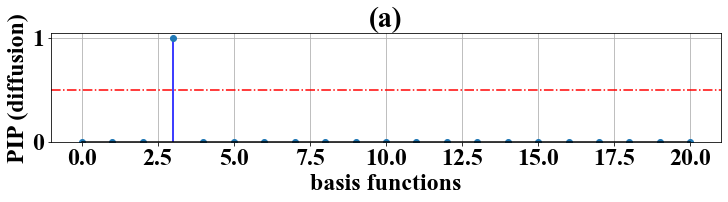

In [29]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (12, 2))
DS['zmean'][0]=0
xr = np.array(range(len(D[1,:])))
plt.stem(xr,DS['zmean'], use_line_collection = True, linefmt='blue', basefmt="k")
plt.axhline(y= 0.5, color='r', linestyle='-.')
plt.xlabel('basis functions',fontweight='bold')
plt.ylabel('PIP (diffusion)', fontweight='bold');
plt.title('(a)', fontweight='bold')
plt.grid(True); plt.ylim(0,1.05)
plt.xticks(fontweight='bold'); plt.yticks(fontweight='bold');
figure1.savefig('duffing_diff_x.pdf',format='pdf',dpi=600,bbox_inches='tight')

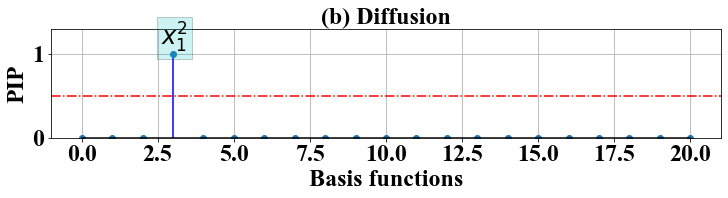

In [38]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (12, 2))
xr = np.array(range(nl))
plt.stem(xr,DS['zmean'], use_line_collection = True, linefmt='blue', basefmt="k")
plt.axhline(y= 0.5, color='r', linestyle='-.')
plt.xlabel('Basis functions',fontweight='bold')
# plt.ylim([0,2])
plt.ylabel('PIP', fontweight='bold');
plt.title('(b) Diffusion', fontweight='bold',fontsize=24)
plt.grid(True); plt.ylim(0,1.3)
plt.xticks(fontweight='bold'); plt.yticks(fontweight='bold');
# plt.text(1.4, 1.1, "$x_1$", bbox=dict(facecolor='c', alpha=0.2), fontsize=24, ha='right')
# plt.text(1.8, 1.1, "$x_2$", bbox=dict(facecolor='c', alpha=0.2), fontsize=24)
plt.text(2.6, 1.1, "$x_1^2$", bbox=dict(facecolor='c', alpha=0.2), fontsize=24)
figure1.savefig('duffing_diff_x.pdf',format='pdf',dpi=600,bbox_inches='tight')

In [ ]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (11.5, 2))
xr = np.array(range(nl))
plt.stem(xr,DS['zmean'], use_line_collection = True, linefmt='blue', basefmt="k")
plt.axhline(y= 0.5, color='r', linestyle='-.')
plt.xlabel('Basis functions',fontweight='bold')
plt.ylabel('PIP (diffusion)', fontweight='bold');
plt.title('(b)Diffusion', fontweight='bold',fontsize=24)
plt.grid(True); plt.ylim(0,1.05)
plt.xticks(fontweight='bold'); plt.yticks(fontweight='bold');
figure1.savefig('duffing_diff.pdf',format='pdf',dpi=600,bbox_inches='tight')

In [25]:
np.sqrt(abs(wmean[0][2]-1000.85))

10.001752595271762